# Pytorch with the MNIST Dataset - MINST

In [60]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [61]:
print(torch.__version__)

2.5.0+cu121


In [81]:
args={}
kwargs={}
args['batch_size']=64 #changed from 32 to 64
args['test_batch_size']=64
args['epochs']=2  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True #if the computer has a GPU, type True, otherwise, False

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

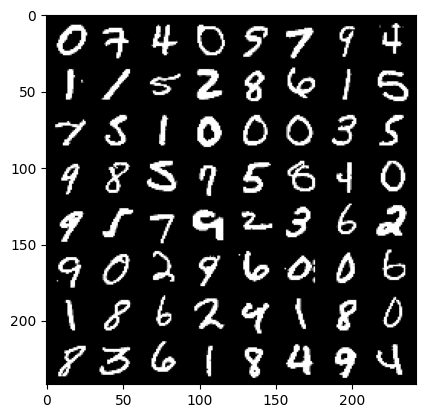

In [64]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [65]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [66]:
# Function Without CNN Layer
class FCNet(nn.Module):
  def __init__(self):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(28*28, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [67]:
# Function With 1 CNN Layer
class CNNet(nn.Module):
  def __init__(self):
    super(CNNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(10*13*13, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = x.view(-1,10*13*13)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [68]:
# Function With 3 CNN Layer
class CNNet2(nn.Module):
  def __init__(self):
    super(CNNet2, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*2*2, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 64*2*2)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [69]:
class CNNet3(nn.Module):
  def __init__(self):
    super(CNNet3, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*1*1, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 64*1*1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [70]:
## test the model with 1 batch
model = FCNet()
#print(model)
for images, labels in train_loader:
    print("batch size:", args['batch_size'])
    out = model(images)
    print(out.shape)
    break

batch size: 64
torch.Size([64, 10])


In [71]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [72]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [73]:
model = FCNet()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294053
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.025987
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.658866
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.460814
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.284282
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.877183
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.788775
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.747307
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.724237
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.554775
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.512398
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.691361
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.691925
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.651222
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.493159
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.489867
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.481258
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.411519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.431742
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.394041
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2591, Accuracy: 9249/10000 (92%)



In [78]:
model = CNNet()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314248
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.154603
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.886095
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.604463
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.359101
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.849808
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.804224
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.466462
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.487307
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.450637
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.468554
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.320117
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.460419
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.431460
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.531040
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.345414
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.623188
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.245944
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.365166
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.568580
Train Epoch: 1 [12800/60000 (

In [79]:
model = CNNet2()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307086
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.317966
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.304671
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.287161
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288270
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.275406
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.271442
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.265383
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.242682
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.247422
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.246098
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.204934
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.185936
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.153238
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.117059
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.046777
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.945886
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.796568
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.565293
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.541717
Train Epoch: 1 [12800/60000 (

In [82]:
model = CNNet3()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.283587
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307360
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.288519
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296549
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.283255
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.277272
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.291511
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.279135
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.268064
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.249232
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.252463
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.244091
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.234550
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.214738
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.205244
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.165524
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.177765
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.146218
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.019390
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.009601
Train Epoch: 1 [12800/60000 (

# **What is the best configuration?**
The best configuration from the experiments is:

**CNN with 3 Layers:**

self.conv1 = nn.Conv2d(1, 16, kernel_size=5)

self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

self.conv3 = nn.Conv2d(32, 64, kernel_size=2)

self.pool = nn.MaxPool2d(2, 2)


**Epochs:** 5

**Learning Rate:** 0.01

# **What prediction accuracy on the test set you got?**
Test Set Accuracy: 99% with an average loss of 0.0454.

The best model setup achieved 99% accuracy by using three convolutional layers with different filter sizes: a 5x5 for broad patterns, followed by 3x3 and 2x2 for finer details. Training for five epochs helped the model learn these patterns effectively.

In simple terms, adding layers and adjusting filter sizes improved the model’s ability to recognize more complex features, resulting in better accuracy. This experiment shows that deeper models trained adequately perform best for this task.

# **What did I learn?**
From this experiment, I learned that:

1.   **More Layers Help:** Adding more layers allowed the model to capture more details, which improved accuracy.
2.   **Filter Sizes Make a Difference:** Starting with a larger filter (like 5x5) helped pick up broader features, while smaller filters in later layers captured finer details.
3.   **Training Needs Time:** Training for enough time (5 epochs) was essential. Complex models need time to fully learn from the data.

In short, using the right number of layers, filter sizes, and training time made the model more accurate.